## Initialize

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
plt.style.use('default')

## Functions

In [ ]:
class CreateUnitStruct:
    def __init__(self, kilosort_path, date):
        self.kilosort_path = kilosort_path
        self.date = date
        self.data_path = directory  
        
        self.spike_time = np.load(os.path.join(self.kilosort_path, "spike_times.npy"))
        self.spike_clusters = np.load(os.path.join(self.kilosort_path, "spike_clusters.npy"))
        self.spike_positions = np.load(os.path.join(self.kilosort_path, "spike_positions.npy"))
        cluster_info_files = ["cluster_info.tsv", "cluster_KSLabel.tsv", "cluster_group.tsv"]
        self.cluster_group = None
        
        for filename in cluster_info_files:
            filepath = os.path.join(self.kilosort_path, filename)
            if os.path.exists(filepath):
                try:
                    self.cluster_group = pd.read_csv(filepath, sep='\t')
                    print(f"Loaded cluster info from: {filename}")
                    break
                except:
                    continue
        
        if self.cluster_group is None:
            print("Warning: Could not load cluster info file")
            # Create minimal cluster info
            unique_clusters = np.unique(self.spike_clusters)
            self.cluster_group = pd.DataFrame({
                'cluster_id': unique_clusters,
                'depth': np.arange(len(unique_clusters)) * 20,  # Dummy depths
                'ch': unique_clusters % 384,  # Dummy channel assignments
                'group': ['good'] * len(unique_clusters)
            })
        
        print(f"Loaded {len(self.spike_time)} spikes from {len(np.unique(self.spike_clusters))} clusters")
        print(f"Cluster info shape: {self.cluster_group.shape}")
        print(f"Cluster info columns: {list(self.cluster_group.columns)}")



In [ ]:
def calculate_binned_firing_rates(unit_creator, stopper_depth_cm, mdi_depth_um, grid_hole_position_mm, bin_size_um=5, bin_width_um=40):
    """
    Calculate firing rates with sliding overlapping bins across Y (depth) positions
    Averages across all X positions within each Y bin
    - bin_size_um: step size between bins (20 μm)
    - bin_width_um: actual width of each bin (40 μm)
    - overlap: (bin_width_um - bin_size_um) / 2 = 10 μm on each side
    """
    
    # Calculate total recording time
    total_time_samples = unit_creator.spike_time[-1] - unit_creator.spike_time[0]
    sampling_rate = 30000
    total_time_seconds = total_time_samples / sampling_rate
    
    print(f"Recording: {total_time_seconds/60:.1f} min")
    print(f"Bin width: {bin_width_um} μm, step: {bin_size_um} μm, overlap: {(bin_width_um-bin_size_um)/2} μm")
    
    # Get spike positions
    x_positions = unit_creator.spike_positions[:, 0]
    z_positions = unit_creator.spike_positions[:, 1]
    
    print(f"Probe depth range: {z_positions.min():.1f} to {z_positions.max():.1f} μm")
    print(f"X position range: {x_positions.min():.1f} to {x_positions.max():.1f} μm")
    
    # Create sliding bin centers for Z (depth)
    z_min = z_positions.min()
    z_max = z_positions.max()
    
    # Bin centers with step size
    bin_centers = np.arange(z_min + bin_width_um/2, z_max - bin_width_um/2 + bin_size_um, bin_size_um)
    
    print(f"Created {len(bin_centers)} sliding bins")
    
    binned_data = []
    
    # For each sliding bin in Z direction
    for bin_center in bin_centers:
        # Define bin edges (centered around bin_center with bin_width_um width)
        bin_start = bin_center - bin_width_um/2
        bin_end = bin_center + bin_width_um/2
        
        # Find all spikes in this Z bin (regardless of X position)
        z_mask = (z_positions >= bin_start) & (z_positions < bin_end)
        
        if np.sum(z_mask) == 0:
            # No spikes in this bin
            spike_count = 0
            firing_rate = 0.0
            x_positions_in_bin = []
        else:
            # Count spikes in this bin
            spike_count = np.sum(z_mask)
            firing_rate = spike_count / total_time_seconds
            
            # Get X positions of spikes in this bin for averaging
            x_positions_in_bin = x_positions[z_mask]
        
        # Calculate average X position for brain coordinate
        if len(x_positions_in_bin) > 0:
            avg_x_position_um = np.mean(x_positions_in_bin)
            unique_x_positions = len(np.unique(x_positions_in_bin))
        else:
            # Use middle of probe if no spikes
            avg_x_position_um = (x_positions.min() + x_positions.max()) / 2
            unique_x_positions = 0
        
        # Calculate brain coordinates
        brain_x_mm =  grid_hole_position_mm[0]
        brain_y_mm = grid_hole_position_mm[1]
        
        # Brain depth calculation
        brain_depth_um = (stopper_depth_cm * 10000) + mdi_depth_um - bin_center
        brain_z_mm = brain_depth_um / 1000
        
        binned_data.append({
            'probe_depth_um': bin_center,
            'brain_x_mm': brain_x_mm,
            'brain_y_mm': brain_y_mm,
            'brain_z_mm': brain_z_mm,
            'bin_start_um': bin_start,
            'bin_end_um': bin_end,
            'bin_width_um': bin_width_um,
            'avg_x_position_um': avg_x_position_um,
            'unique_x_positions': unique_x_positions,
            'spike_count': spike_count,
            'firing_rate_hz': firing_rate
        })
    
    return pd.DataFrame(binned_data), total_time_seconds, bin_size_um, bin_width_um

def process_session(date, directory, subject, kilosort, stopper_depth_cm, mdi_depth_um, grid_hole_position_mm, bin_width_um=60):
    """Process a single session and return binned data"""
    
    # Handle special folder naming
    if '_' in date:
        folder_name = date
        session_name = date
    else:
        folder_name = date
        session_name = date
    
    kilosort_path = os.path.join(directory, folder_name, kilosort)
    
    print(f"\n=== Processing {session_name} ===")
    print(f"Path: {kilosort_path}")
    print(f"Stopper: {stopper_depth_cm}cm, MDI: {mdi_depth_um}μm, Grid: {grid_hole_position_mm}mm")
    
    if not os.path.exists(kilosort_path):
        print(f"ERROR: Path does not exist: {kilosort_path}")
        return None
    
    try:
        unit_creator = CreateUnitStruct(kilosort_path, session_name)
        binned_df, recording_time, bin_step, bin_width = calculate_binned_firing_rates(
            unit_creator, stopper_depth_cm, mdi_depth_um, grid_hole_position_mm, bin_width_um=bin_width_um)
        
        print(f"Success: {len(binned_df)//2} bins per column")
        return binned_df
    
    except Exception as e:
        print(f"ERROR processing {session_name}: {e}")
        return None

## Main

In [ ]:
directory = r"D:"
subject = "zarya"
kilosort = "kilosort4"

# Define all sessions
sessions = [
    {
        'date': '20241220',
        'stopper_depth_cm': 1.8,
        'mdi_depth_um': 11000,
        'grid_hole_position_mm': [3, -3]
    },
    {
        'date': '20250718',
        'stopper_depth_cm': 1.7,
        'mdi_depth_um': 8000,
        'grid_hole_position_mm': [-2, -2]
    },
    {
        'date': '20250724_6836',
        'stopper_depth_cm': 1.7,
        'mdi_depth_um': 6836,
        'grid_hole_position_mm': [-1, -4]
    },
    {
        'date': '20250724_10722',
        'stopper_depth_cm': 1.7,
        'mdi_depth_um': 10722,
        'grid_hole_position_mm': [-1, -4]
    },
    {
        'date': '20250801',
        'stopper_depth_cm': 1.7,
        'mdi_depth_um': 12496,
        'grid_hole_position_mm': [0, -3]
    }
]

# Process all sessions
all_sessions_data = []
successful_sessions = []

for session in sessions:
    binned_df = process_session(
        session['date'], directory, subject, kilosort,
        session['stopper_depth_cm'], session['mdi_depth_um'], 
        session['grid_hole_position_mm']
    )
    
    if binned_df is not None:
        all_sessions_data.append(binned_df)
        successful_sessions.append(session)

print(f"\n=== SUMMARY ===")
print(f"Successfully processed: {len(successful_sessions)}/{len(sessions)} sessions")
for session in successful_sessions:
    print(f"  ✓ {session['date']}")

## Plot

In [ ]:
# Interactive 3D
import plotly.graph_objects as go

fig = go.Figure()
for i, (binned_df, session) in enumerate(zip(all_sessions_data, successful_sessions)):
    active_mask = binned_df['firing_rate_hz'] > 0
    if np.sum(active_mask) > 0:
        fig.add_trace(go.Scatter3d(
            x=binned_df['brain_y_mm'][active_mask],
            y=binned_df['brain_x_mm'][active_mask], 
            z=binned_df['brain_z_mm'][active_mask] * (-1) + 17,
            mode='markers',
            marker=dict(
                size=binned_df['firing_rate_hz'][active_mask] / 5,
                color=binned_df['firing_rate_hz'][active_mask],
                colorscale='viridis',
                colorbar=dict(title="Firing Rate (Hz)"),
                opacity=0.8,
                cmin=0, cmax=100, line=dict(width=0)
            ),
            name=session['date'],
            text=[f"Firing Rate: {fr:.1f} Hz<br>Depth: {d:.1f} mm" 
                  for fr, d in zip(binned_df['firing_rate_hz'][active_mask], 
                                  binned_df['brain_z_mm'][active_mask])],
            hovertemplate='%{text}<extra></extra>'
        ))

fig.update_layout(
    title=f'Interactive Neural Activity - {subject}',
    scene=dict(
        xaxis_title='Y Position (mm)<br>← Anterior |  Posterior →',
        yaxis_title='X Position (mm)<br>← Medial | Lateral →',
        zaxis_title='Brain Depth (mm)<br>← Deep | Surface →',
        aspectmode='cube'
    )
)

fig.show()


C:\Users\fetschlab\AppData\Local\Temp\ipykernel_13284\1244566765.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



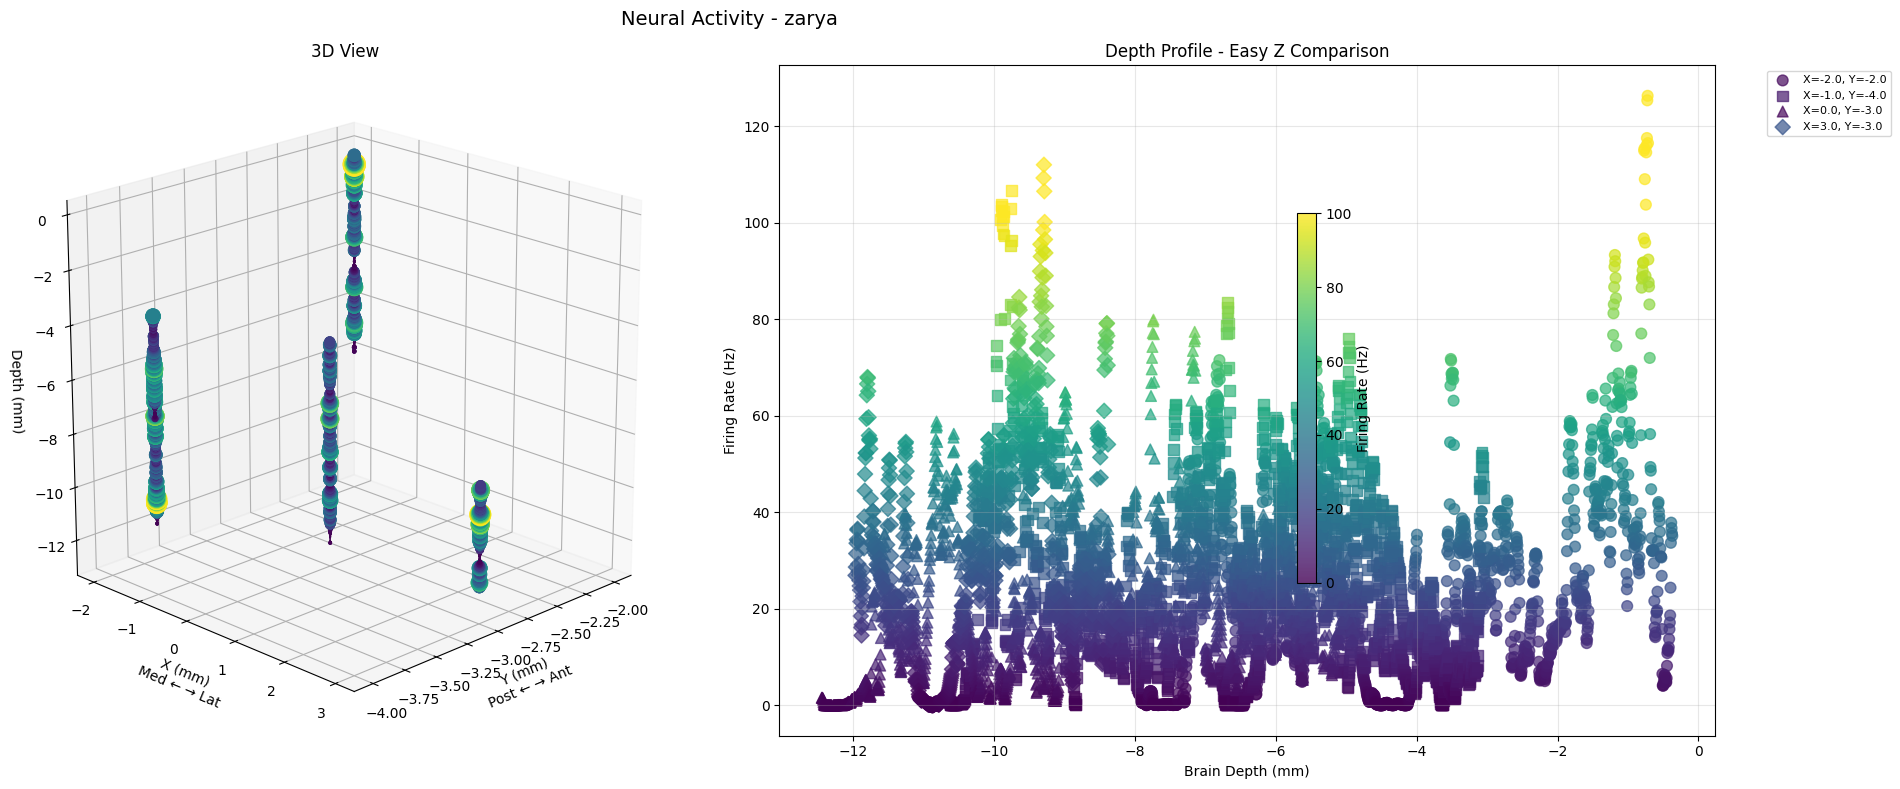

In [51]:
if len(all_sessions_data) > 0:
    fig = plt.figure(figsize=(20, 8))
    
    # 3D plot (left)
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Combine data for 2D plot
    all_data = []
    colors = plt.cm.Set1(np.linspace(0, 1, len(successful_sessions)))
    
    for i, (binned_df, session) in enumerate(zip(all_sessions_data, successful_sessions)):
        active_mask = binned_df['firing_rate_hz'] > 0
        
        if np.sum(active_mask) > 0:
            # 3D scatter
            firing_rates = binned_df['firing_rate_hz'][active_mask]
            normalized_sizes = (firing_rates / 100) * 200
            
            scatter = ax1.scatter(binned_df['brain_y_mm'][active_mask], 
                                 binned_df['brain_x_mm'][active_mask], 
                                 binned_df['brain_z_mm'][active_mask] * (-1) + 17,
                                 c=firing_rates, 
                                 s=normalized_sizes,
                                 cmap='viridis', alpha=0.8,
                                 marker='o', vmin=0, vmax=100)
            
            # Collect data for 2D plot
            active_data = binned_df[active_mask].copy()
            active_data['session'] = session['date']
            active_data['session_color'] = i
            all_data.append(active_data)
    
    # 3D plot styling
    ax1.set_box_aspect([1,1,1])
    ax1.set_xlabel('Y (mm)\nPost ← → Ant', fontsize=10)
    ax1.set_ylabel('X (mm)\nMed ← → Lat', fontsize=10)
    ax1.set_zlabel('Depth (mm)', fontsize=10)
    ax1.set_title('3D View', fontsize=12)
    ax1.invert_xaxis()
    ax1.view_init(elev=20, azim=45)
    
    # 2D depth profile (right)
    ax2 = fig.add_subplot(122)
    
    if all_data:
        combined_data = pd.concat(all_data)
        
        # Plot each location with different symbols
        locations = combined_data.groupby(['brain_x_mm', 'brain_y_mm'])
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
        
        for i, ((x, y), group) in enumerate(locations):
            marker = markers[i % len(markers)]
            ax2.scatter(group['brain_z_mm'] * -1 + 17, group['firing_rate_hz'],
                       c=group['firing_rate_hz'], cmap='viridis', 
                       s=60, alpha=0.7, marker=marker,
                       label=f'X={x:.1f}, Y={y:.1f}', vmin=0, vmax=100)
        
        ax2.set_xlabel('Brain Depth (mm)')
        ax2.set_ylabel('Firing Rate (Hz)')
        ax2.set_title('Depth Profile - Easy Z Comparison')
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Shared colorbar
    if scatter is not None:
        plt.colorbar(scatter, ax=[ax1, ax2], shrink=0.6, label='Firing Rate (Hz)')
    
    plt.suptitle(f'Neural Activity - {subject}', fontsize=14)
    plt.tight_layout()
    plt.show()

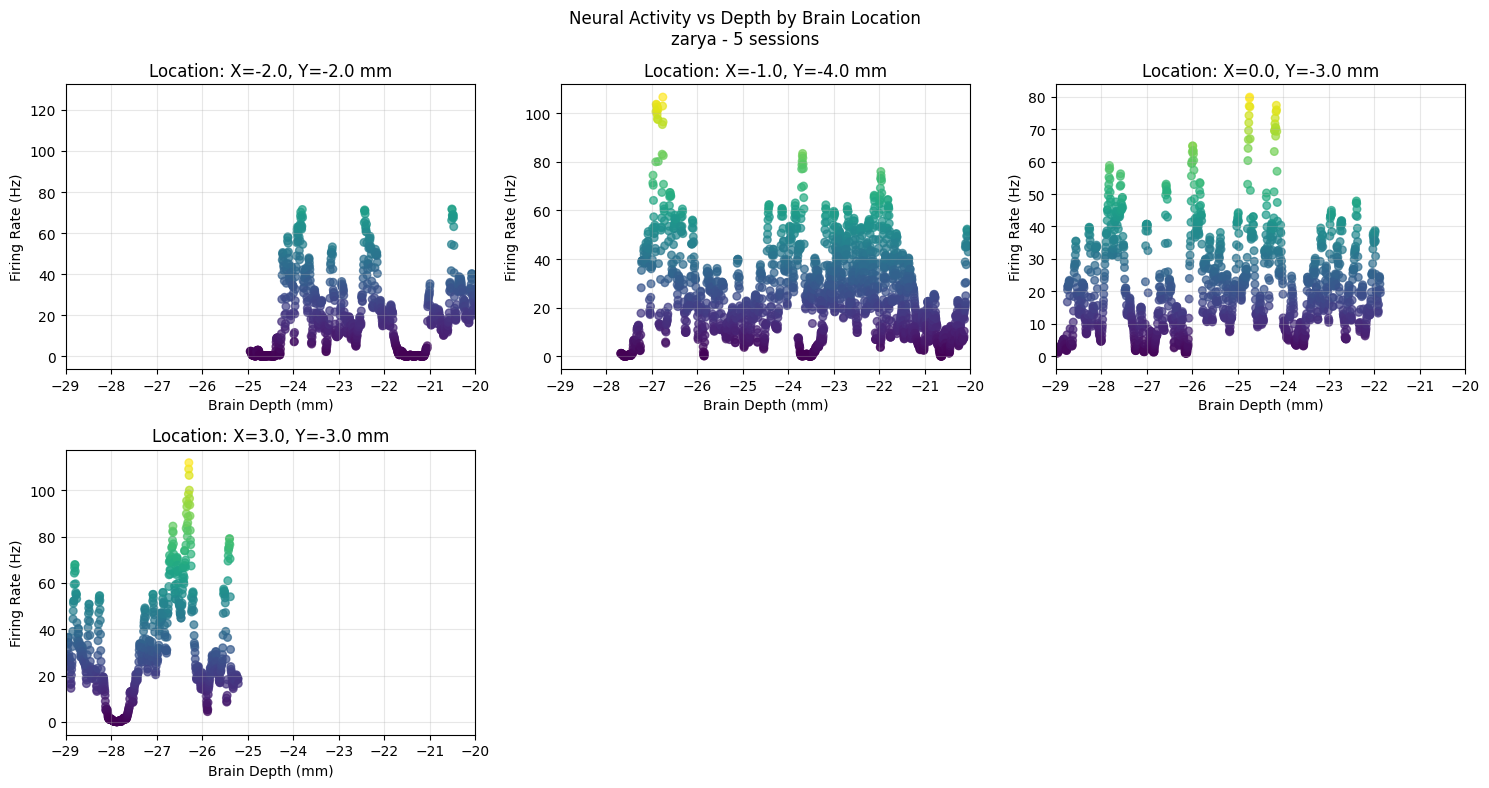

In [27]:
if len(all_sessions_data) > 0:
    # Combine all data
    all_data = []
    for binned_df, session in zip(all_sessions_data, successful_sessions):
        active_data = binned_df[binned_df['firing_rate_hz'] > 0].copy()
        active_data['session'] = session['date']
        all_data.append(active_data)
    
    if all_data:
        combined_data = pd.concat(all_data)
        
        # Group by brain location (X,Y coordinates)
        locations = combined_data.groupby(['brain_x_mm', 'brain_y_mm'])
        n_locations = len(locations)
        
        # Create subplots
        cols = min(3, n_locations)
        rows = (n_locations + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        if n_locations == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        for i, ((x, y), group) in enumerate(locations):
            if i < len(axes):
                scatter = axes[i].scatter(group['brain_z_mm'] * -1, group['firing_rate_hz'], 
                                        c=group['firing_rate_hz'], cmap='viridis', 
                                        s=30, alpha=0.7)
                axes[i].set_xlabel('Brain Depth (mm)')
                axes[i].set_ylabel('Firing Rate (Hz)')
                axes[i].set_title(f'Location: X={x:.1f}, Y={y:.1f} mm')
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim(-29, -20)
        
        # Hide unused subplots
        for i in range(n_locations, len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(f'Neural Activity vs Depth by Brain Location\n{subject} - {len(successful_sessions)} sessions')
        plt.tight_layout()
        plt.show()

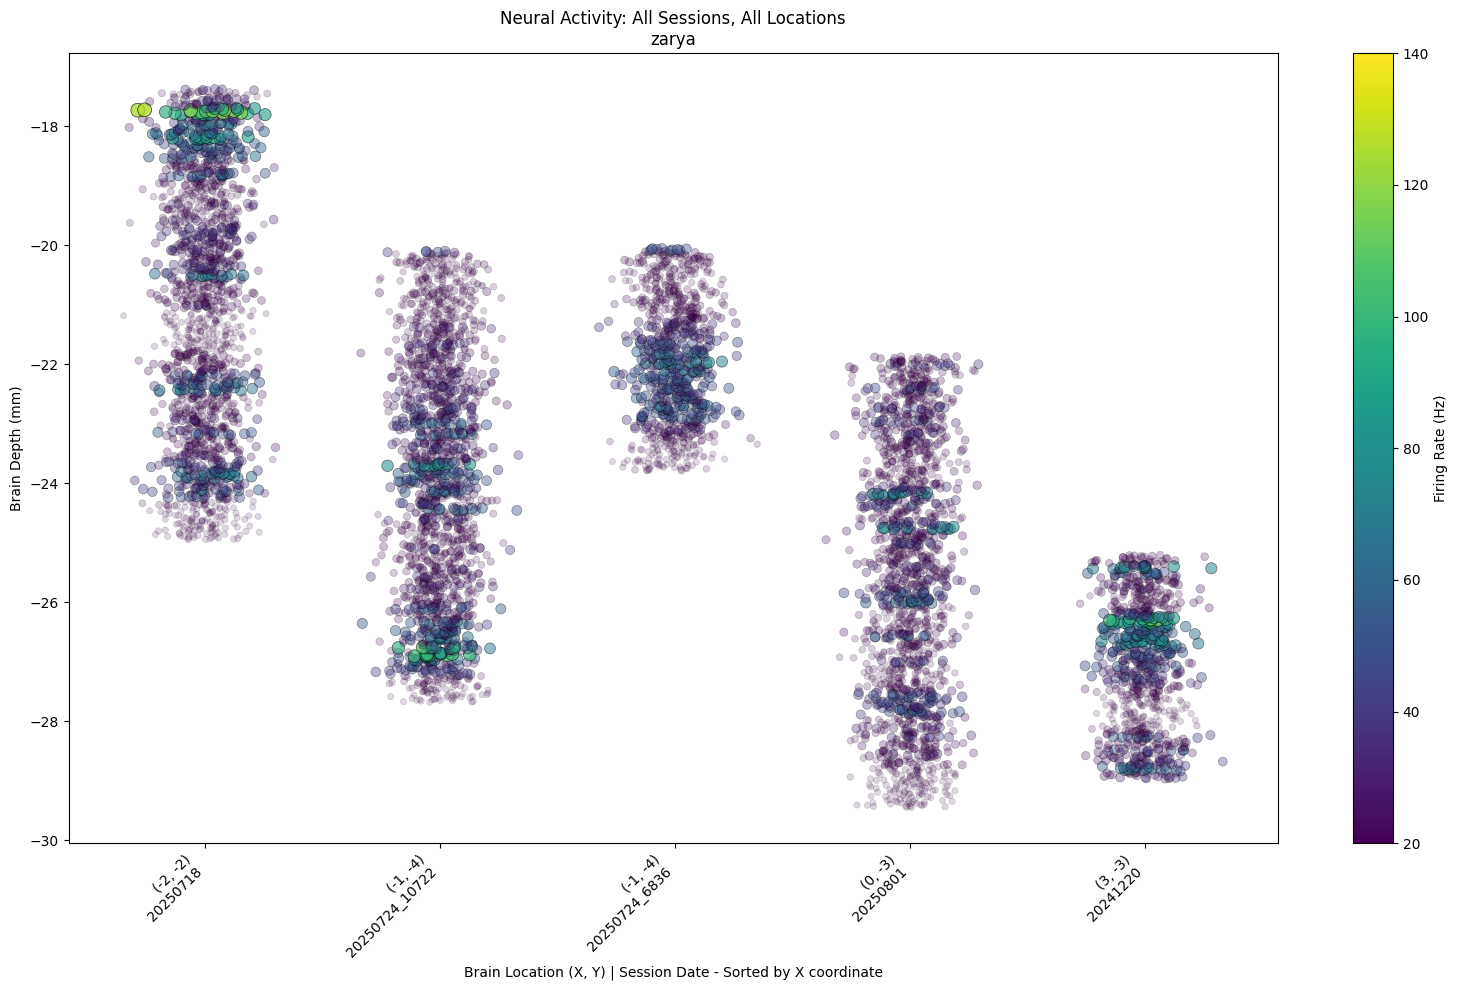

In [ ]:
if len(all_sessions_data) > 0:
    # Combine all data
    all_data = []
    for i, (binned_df, session) in enumerate(zip(all_sessions_data, successful_sessions)):
        active_data = binned_df[binned_df['firing_rate_hz'] > 0].copy()
        active_data['session'] = session['date']
        active_data['grid_position'] = f"[{session['grid_hole_position_mm'][0]}, {session['grid_hole_position_mm'][1]}]"
        all_data.append(active_data)
    
    if all_data:
        combined_data = pd.concat(all_data)
        
        fig, ax = plt.subplots(figsize=(16, 10))  

        combined_data['xy_position'] = combined_data['brain_x_mm'].astype(str) + ', ' + combined_data['brain_y_mm'].astype(str)
        combined_data['position_date'] = combined_data['xy_position'] + ' | ' + combined_data['session']
        
        unique_combinations_df = combined_data[['brain_x_mm', 'brain_y_mm', 'xy_position', 'session', 'grid_position', 'position_date']].drop_duplicates()
        unique_combinations_df = unique_combinations_df.sort_values(['brain_x_mm', 'brain_y_mm', 'session'])  # Sort by X, Y, then date
        unique_combinations_sorted = unique_combinations_df['position_date'].tolist()
        
        position_numbers = {pos: i for i, pos in enumerate(unique_combinations_sorted)}
        combined_data['xy_numeric'] = combined_data['position_date'].map(position_numbers)
        
        jitter = np.random.normal(0, 0.1, len(combined_data))
        
        firing_rates = combined_data['firing_rate_hz']
        normalized_sizes = 20 + (firing_rates / firing_rates.max()) * 80  
        
        scatter = ax.scatter(combined_data['xy_numeric'] + jitter, 
                           combined_data['brain_z_mm'] * -1,
                           c=combined_data['firing_rate_hz'], 
                           cmap='viridis', 
                           s=normalized_sizes, 
                           alpha=normalized_sizes * 0.8 / 100, 
                           edgecolors='black',
                           linewidths=0.5,
                           vmin=20, vmax=140)
        
        ax.set_xlabel('Brain Location (X, Y) | Session Date - Sorted by X coordinate')
        ax.set_ylabel('Brain Depth (mm)')
        ax.set_title(f'Neural Activity: All Sessions, All Locations\n{subject}')
        ax.set_xticks(range(len(unique_combinations_sorted)))
        
        # Create better labels with position and date
        labels = []
        for _, row in unique_combinations_df.iterrows():
            label = f"({row['xy_position']})\n{row['session']}"
            labels.append(label)
        
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        plt.colorbar(scatter, ax=ax, label='Firing Rate (Hz)')
        plt.tight_layout()
        plt.show()

In [ ]:
if len(all_sessions_data) > 0:
    # Combine all data
    all_data = []
    for i, (binned_df, session) in enumerate(zip(all_sessions_data, successful_sessions)):
        active_data = binned_df[binned_df['firing_rate_hz'] > 0].copy()
        active_data['session'] = session['date']
        all_data.append(active_data)
    
    if all_data:
        combined_data = pd.concat(all_data)
        
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Normalize firing rates for alpha (0.2 to 0.9 range)
        firing_rates = combined_data['firing_rate_hz']
        normalized_alpha = 0.2 + 0.7 * (firing_rates - firing_rates.min()) / (firing_rates.max() - firing_rates.min())
        
        scatter = ax.scatter(combined_data['brain_x_mm'], 
                           combined_data['brain_y_mm'], 
                           combined_data['brain_z_mm'] * -1,
                           c=combined_data['firing_rate_hz'], 
                           cmap='Blues', s=50, alpha=0.8, 
                           vmin=20, vmax=80)
        
        # Make axes more comparable
        ax.set_box_aspect([1,1,1])  # Equal aspect ratio for all axes
        
        ax.set_xlabel('X Position (mm)')
        ax.set_ylabel('Y Position (mm)')
        ax.set_zlabel('Brain Depth (mm)')
        ax.set_title(f'Neural Activity: All Sessions, All Locations (3D)\n{subject}')
        
        plt.colorbar(scatter, ax=ax, shrink=0.6, label='Firing Rate (Hz)')
        
        ax.view_init(elev=20, azim=45)
        plt.tight_layout()
        plt.show()

## Archive

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot both groups
for i, group_name in enumerate(['X<50', 'X>=50']):
    group_data = binned_df[binned_df['x_group'] == group_name]
    active_mask = group_data['firing_rate_hz'] > 0
    
    if np.sum(active_mask) > 0:
        scatter = ax.scatter(group_data['brain_x_mm'][active_mask], 
                            group_data['brain_y_mm'][active_mask], 
                            group_data['brain_z_mm'][active_mask],
                            c=group_data['firing_rate_hz'][active_mask], 
                            s=100, cmap='viridis', alpha=0.8,
                            marker='o',
                            edgecolors='none', linewidth=0.5)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Brain Depth (mm)')
ax.set_title(f'Neural Activity - {date}')
ax.legend()

if 'scatter' in locals():
    plt.colorbar(scatter, ax=ax, shrink=0.8, label='Firing Rate (Hz)')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 5: Depth profile comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Depth profiles
colors = ['blue', 'red']
for i, group_name in enumerate(['X<50', 'X>=50']):
    group_data = binned_df[binned_df['x_group'] == group_name]
    active_data = group_data[group_data['firing_rate_hz'] > 0]
    
    ax1.plot(active_data['firing_rate_hz'], active_data['brain_z_mm'], 
             'o-', color=colors[i], alpha=0.7, markersize=4, label=group_name)

ax1.set_xlabel('Firing Rate (Hz)')
ax1.set_ylabel('Brain Depth (mm)')
ax1.set_title('Firing Rate vs Depth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Activity heatmap
pivot_data = binned_df.pivot_table(values='firing_rate_hz', 
                                   index='brain_z_mm', 
                                   columns='x_group', 
                                   fill_value=0)

im = ax2.imshow(pivot_data.values, aspect='auto', cmap='hot',
                extent=[0, len(pivot_data.columns), 
                       pivot_data.index.max(), pivot_data.index.min()])
ax2.set_xticks(range(len(pivot_data.columns)))
ax2.set_xticklabels(pivot_data.columns)
ax2.set_ylabel('Brain Depth (mm)')
ax2.set_title('Activity Heatmap')
plt.colorbar(im, ax=ax2, label='Firing Rate (Hz)')

plt.tight_layout()
plt.show()